# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
import rsnapsim as rss

from skimage.exposure import rescale_intensity
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

#trajectiories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','kdm5b_ssa.npy')
#gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')

trajectiories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','Bactin_withTags.txt')



In [3]:
# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [4]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 1 # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 30    # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 100     # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient = 0.2    # PLEASE TEST MIN 0.1 MAX 2

In [5]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 1 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'

In [6]:
particle_size = 5 # spot size for the simulation and tracking.
elongation_rate = 5
initiation_rate = 0.03

In [7]:
intensity_scale_ch0 = 60
intensity_scale_ch1 = 60
intensity_scale_ch2 = 60

In [8]:
particle_detection_size = particle_size

In [9]:
def rsnapsim_ssa(gene_file,ke,ki,frames=300,frame_rate=1,n_traj=20):
    '''
    This function uses rsnapsim to simulate the single-molecule translation dynamcis of any gene.
    Inputs:
    gene_file : str, with the location of a fasta file.
    ke : float, elonation rate.
    ki: float, initation rate.
    frames: int, total number of simulation frames in seconds.
    n_traj: int, number of trajectories to simulate
    frame_rate : int, frame rate per second
    Outputs:
    ssa_int : NumPy array with dimenssions [Time_points, simulated_trajectories]
    '''
    poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(str(gene_file))
    gene_obj = tagged_pois['1'][0]
    gene_obj.ke_mu = ke
    rss.solver.protein = gene_obj #pass the protein object
    t_burnin = 1000
    t = np.linspace(0,t_burnin+frames,(t_burnin+frames+1)*(frame_rate))
    number_probes = np.amax(gene_obj.probe_vec)
    ints = []
    #for i in tq.tqdm(range(n_traj)):
    counter = 0
    while counter < n_traj:
      ssa_solution = rss.solver.solve_ssa(gene_obj.kelong, t, ki=ki, kt = ke, low_memory=True,record_stats=False,n_traj=1)
      ssa_int =  ssa_solution.intensity_vec[0,t_burnin*frame_rate:-1,:]
      if np.mean(ssa_int)> 1:
        ints.append(ssa_int)
        counter +=1
    ssa = np.array(ints).reshape(n_traj,frames) #flatten the lists back to a numpy array

    ssa_ump = ssa/number_probes
    return ssa, ssa_ump, gene_obj, t,number_probes

## Running the simulations

In [10]:
def fun_simulated_cells(current_dir, video_dir,ke=3,ki=0.03,gene_file =None, trajectiories_dir=None, number_of_simulated_cells=3,number_spots_per_cell=80,simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1,path_to_rSNAPsim= None, path_to_save_output='temp',intensity_calculation_method='gaussian_fit',frame_selection_empty_video=frame_selection_empty_video):
    spot_size = particle_size
    spot_sigma = 1
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        ouput_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        video_path = path_files[counter]        
        video = imread(video_path) 

        # Reducing in a half the intensity in the original video
        video = video//2

        counter +=1
        if counter>=len(path_files):
            counter =0
        if not (trajectiories_dir is None ):
            # Loading trajectories from file
            ssa_trajectories = np.load(str(trajectiories_dir))
            random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec]
            simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec]
        else:
            # Simulations for intensity
            ssa1,ssa1_ump,_,_,number_probes = rsnapsim_ssa(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell) # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch1 = ssa1_ump
            ssa2,ssa1_ump,_,_,number_probes =  rsnapsim_ssa(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell) # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch2 = ssa1_ump
        simulated_trajectories_ch0 = None
        simulated_trajectories_ch0 = simulated_trajectories_ch1
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        tensor_video , spot_positions_movement, DataFrame_particles_intensities = rsp.SimulatedCell( base_video=video, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=simulated_trajectories_ch0, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=1,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=1,frame_selection_empty_video=frame_selection_empty_video ,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path

In [11]:
# running the simulation
start = timer()
ouput_directory_name = fun_simulated_cells(current_dir,video_dir,ke=3, ki=0.03,trajectiories_dir=None,gene_file= gene_file, number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video)
end = timer()
print('Time to generate simulated data:',round(end - start), ' sec')

Time to generate simulated data: 31  sec


In [12]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
list_videos_original = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

In [13]:
# Rescaling images
rescale_video = False
if rescale_video == True:
    list_videos = []
    number_channels = list_videos_original[0].shape[-1]
    number_z_slices = list_videos_original[0].shape[0]
    for i in range (0,nimg ):
        temp_img = np.zeros_like(list_videos_original[0])
        for j in range(0,number_channels):
            temp_img[:,:,:,j] =  np.asarray( [ rescale_intensity(list_videos_original[i][z,:,:,j], in_range='image', out_range='dtype')  for z in range (0, number_z_slices)]  )
        list_videos.append(temp_img)
else:
    list_videos = list_videos_original

In [14]:
# Reads the dataframes
list_files_dfnames = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.csv') in f], key=str.lower)  # reading all tif files in the folder
list_files_dfnames.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files_df = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_dfnames ] # creating the complete path for each file
list_df_real_positions = [pd.read_csv(f) for f in  path_files_df] # List with all the videos

## Display results as images

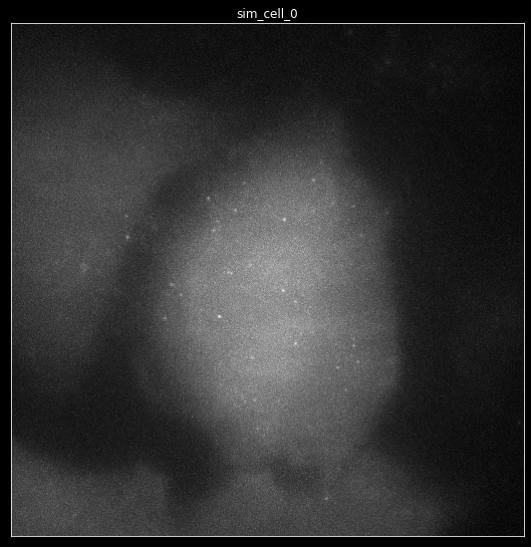

In [15]:
# Showing the simulated images
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =0,selected_timepoint= 0,normalize=0,individual_figure_size=10).plot()

  0%|          | 0/1 [00:00<?, ?it/s]

mask time: 5  sec


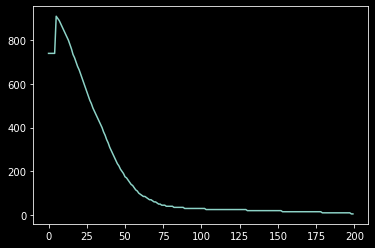

tracking time: 8  sec
intensity calculation time: 5  sec


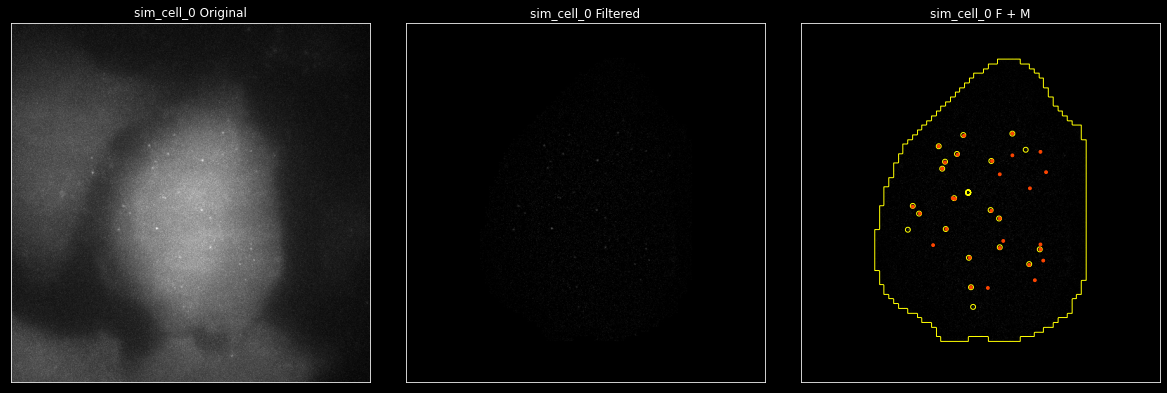

In [16]:
#intensity_selection_method =intensity_selection_method, mask_selection_method = mask_selection_method
list_DataFrame_particles_intensities= []
#list_array_intensities = []
#list_time_vector = []
for i in tqdm(range(0,nimg)): 
    DataFrame_particles_intensities, _, _, _,_, _, _ = rsp.PipelineTracking(list_videos[i],particle_size=particle_detection_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=1,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = list_df_real_positions[i],average_cell_diameter=200,print_process_times=1).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)
    #list_array_intensities.append(array_intensities)
    #list_time_vector.append(time_vector)

In [17]:
list_DataFrame_particles_intensities
df =list_DataFrame_particles_intensities[0]
df

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y,SNR_red,SNR_green,SNR_blue,background_int_mean_red,background_int_mean_green,background_int_mean_blue,background_int_std_red,background_int_std_green,background_int_std_blue
0,0,0,0,87.839996,75.32,0.0,96.141429,172.002958,0.0,301.022995,157.003209,14.309848,13.976937,NaN,755.660706,1848.660767,0.0,58.200478,137.034317,0.0
1,0,0,1,89.199997,76.68,0.0,97.767070,173.249351,0.0,301.021556,157.002629,14.333216,13.986861,NaN,755.660706,1848.660767,0.0,58.200478,137.034317,0.0
2,0,0,2,89.199997,76.68,0.0,97.767070,173.249351,0.0,301.021556,157.002629,14.333216,13.986861,NaN,755.660706,1848.660767,0.0,58.200478,137.034317,0.0
3,0,0,3,89.199997,76.68,0.0,97.767070,173.249351,0.0,301.021556,157.002629,14.333216,13.986861,NaN,755.660706,1848.660767,0.0,58.200478,137.034317,0.0
4,0,0,4,76.000000,63.48,0.0,84.836784,163.817733,0.0,301.025751,157.002452,14.106413,13.890535,NaN,755.660706,1848.660767,0.0,58.200478,137.034317,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420,0,30,95,53.220001,50.32,0.0,89.384348,156.106046,0.0,232.928000,158.939000,13.483923,12.576521,NaN,677.892883,1620.607178,0.0,53.895294,132.733047,0.0
2421,0,30,96,42.560001,39.16,0.0,75.170249,147.222737,0.0,232.928000,158.939000,13.359222,12.517908,NaN,677.196411,1619.910767,0.0,53.413288,132.303253,0.0
2422,0,30,97,42.560001,39.16,0.0,75.170249,147.222737,0.0,232.928000,158.939000,13.359222,12.517908,NaN,677.196411,1619.910767,0.0,53.413288,132.303253,0.0
2423,0,30,98,42.560001,39.16,0.0,75.170249,147.222737,0.0,232.928000,158.939000,13.359222,12.517908,NaN,677.196411,1619.910767,0.0,53.413288,132.303253,0.0


In [18]:
all_data = True
sel_timepoint = 0

In [19]:
print(list_videos[0][0,:,:,0].mean())

541.7638816833496


# Intensity vs SNR

slope 0.027413215088241037
intercept 15.45721676844477


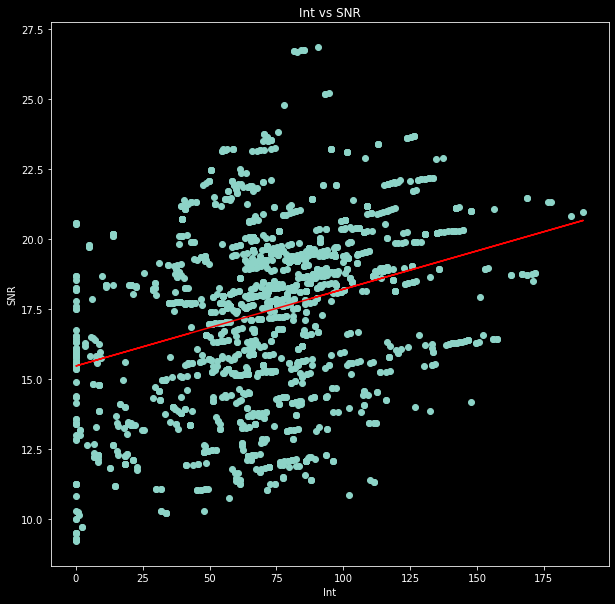

In [20]:
if all_data == True:
    x = df.red_int_mean.values
    y = df.SNR_red.values
else:
    x = df[df['frame'] ==sel_timepoint].red_int_mean.values
    y = df[df['frame'] ==sel_timepoint].SNR_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('Int vs SNR')
plt.ylabel('SNR')
plt.xlabel('Int')
plt.show()

# Intensity vs Noise (mean_background_int)

slope -0.11589098166159639
intercept 830.9097167630654


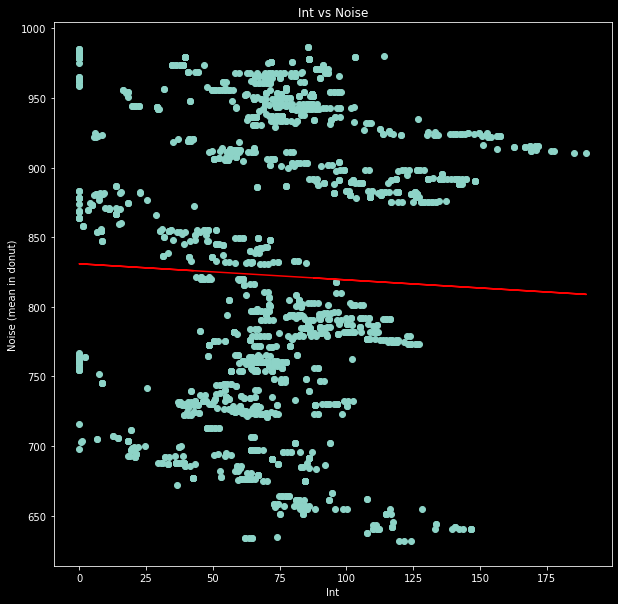

In [21]:
if all_data == True:
    x = df.red_int_mean.values
    y = df.background_int_mean_red.values
else:
    x = df[df['frame'] ==sel_timepoint].red_int_mean.values
    y = df[df['frame'] ==sel_timepoint].background_int_mean_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('Int vs Noise')
plt.ylabel('Noise (mean in donut)')
plt.xlabel('Int')
plt.show()

# SNR vs Noise (mean_background_int)

slope 0.009974615421289598
intercept 9.161707775120796


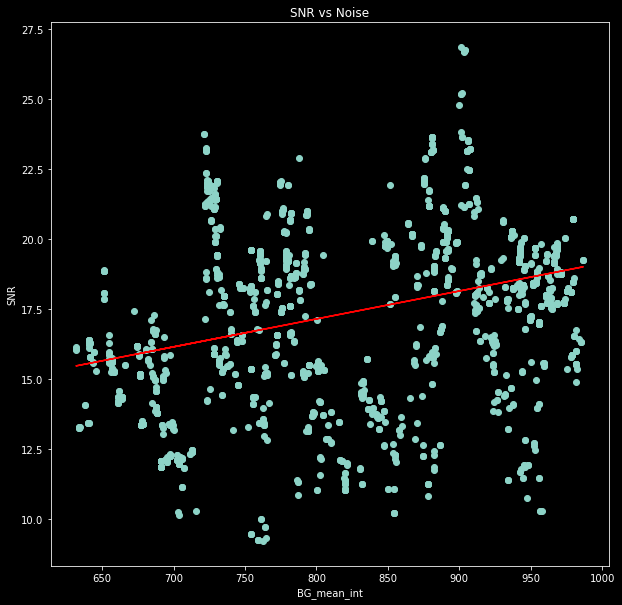

In [22]:
if all_data == True:
    y = df.SNR_red.values
    x = df.background_int_mean_red.values
else:
    y = df[df['frame'] ==sel_timepoint].SNR_red.values
    x = df[df['frame'] ==sel_timepoint].background_int_mean_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('SNR vs Noise')
plt.xlabel('BG_mean_int')
plt.ylabel('SNR')
plt.show()

# BG_Int_std vs SNR 

slope -0.24195598392137652
intercept 30.004292051143228


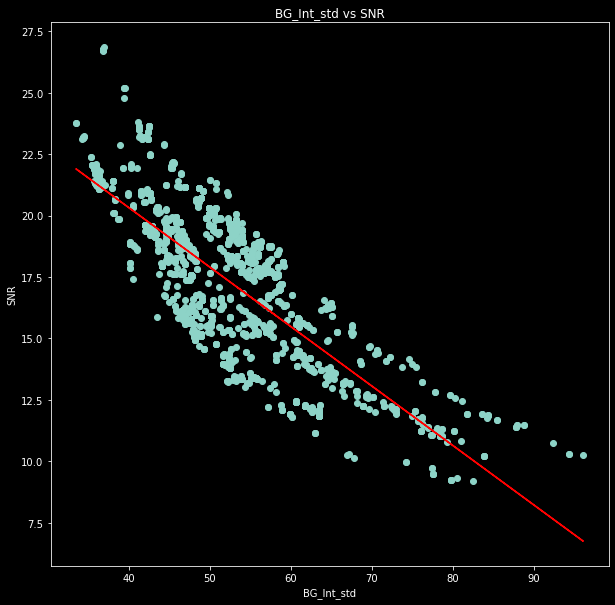

In [23]:
if all_data == True:
    x = df.background_int_std_red.values
    y = df.SNR_red.values
else:
    x = df[df['frame'] ==sel_timepoint].background_int_std_red.values
    y = df[df['frame'] ==sel_timepoint].SNR_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('BG_Int_std vs SNR')
plt.ylabel('SNR')
plt.xlabel('BG_Int_std')
plt.show()

# SNR distribution

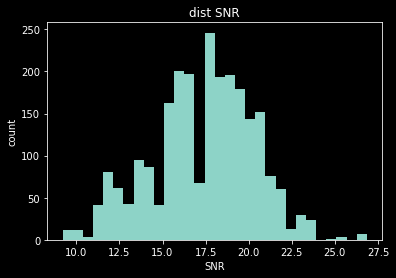

In [24]:
plt.hist(df.SNR_red.values,bins=30)
plt.title('dist SNR')
plt.ylabel('count')
plt.xlabel('SNR')
plt.show()